<a href="https://colab.research.google.com/github/RSNA/AI-Deep-Learning-Lab-2021/blob/main/sessions/nlp-text-classification/RSNA21_DLL_NLP_Transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **RSNA21: Deep Learning Lab**

## **NLP: Text Classification with Transformers**

In this demonstration, we will utilize techniques of _natural language processing_ (NLP) to train a classifier, which will analyze the text of radiology reports for chest radiographs to predict whether a report is **normal** or **abnormal**.

### Code
We will utilize the **HuggingFace** [Transformers](https://huggingface.co/transformers/) and [Datasets](https://huggingface.co/datasets) libraries. These libraries are written primarily in the [Python programming language](https://www.python.org/) and can be used with both the [PyTorch](https://www.pytorch.org/) and [TensorFlow](https://www.tensorflow.org/) deep learning libraries. 

The demonstration in this notebook relies heavily on examples from the [HuggingFace Course](https://huggingface.co/course/chapter1).

### Data

The data is obtained from the National Library of Medicine's Open-i service. We utilize the radiology reports from the [Indiana University Chest X-ray Dataset](https://openi.nlm.nih.gov/faq#collection) for this demonstration.

> _Reference:_ Demner-Fushman D, Kohli MD, Rosenman MB, Shooshan SE, Rodriguez L, Antani S, Thoma GR, McDonald CJ. Preparing a collection of radiology examinations for distribution and retrieval. J Am Med Inform Assoc. 2016 Mar;23(2):304-10. doi: 10.1093/jamia/ocv080. Epub 2015 Jul 1. 

### Developer
- Walter F. Wiggins, MD, PhD - Duke University Hospital, Durham, NC, USA

### Acknowledgements
- Felipe Kitamura, MD - UNIFESP, Sao Paulo, Brasil
- Igor Santos, MD - UNIFESP, Sao Paulo, Brasil
- Luciano M. Prevedello, MD, MPH - Ohio State University, Columbus, OH, USA

# System Setup & Downloading the Data

When you run the following cell, two things will happen:
1. The necessary code libraries will be installed.
2. Next, the [NLM Open-i "Indiana University Chest X-ray Reports" dataset](https://openi.nlm.nih.gov/faq#collection) will be downloaded.

In [ ]:
#@title **Setting up the runtime environment...**

%%capture

# Install libraries
!pip install fastcore==1.3.27
!pip install transformers==4.12.2
!pip install datasets==1.15.1
!pip install xmltodict==0.12.0

# Download the data
!curl -s https://openi.nlm.nih.gov/imgs/collections/NLMCXR_reports.tgz | tar xvz


# Reformatting the Data

Each of the reports is stored in _extensible markup language_ (XML) format. In order to work with the report text data more easily, we will extract the data and put it into a `pandas.DataFrame`, which is a tabular data structure.

The XML metadata contains [MeSH terms](https://www.ncbi.nlm.nih.gov/mesh/) for each report. We will use these to create the _label_ for each report in our dataset. These labels will serve as the targets for training our classifier to predict whether the report is **normal** or **abnormal**.

In [ ]:
#@title **Extracting the data...**

#@markdown After the relevant data is extracted from the XML files, the total number of reports and the first 5 rows of our data table will show up below.

import glob
import xmltodict
import pandas as pd
from fastcore.foundation import L

# suppress warnings from the output
import warnings
warnings.filterwarnings('ignore')


def xml_parse(f):
    with open(f) as xml:
        report_dict = xmltodict.parse(xml.read())
    xml.close()
    return report_dict

def get_label(report):
    label = L(report['eCitation']['MeSH']['major'])
    return 'normal' if label[0].lower() == 'normal' else 'abnormal'

def get_text(report):
    text_dict = {}
    text_dict['id'] = report['eCitation']['IUXRId']['@id']
    text = report['eCitation']['MedlineCitation']['Article']['Abstract']['AbstractText']
    findings = text[2]['#text'] if '#text' in text[2] else ''
    text_dict['findings'] = findings
    impression = text[3]['#text'] if '#text' in text[3] else ''
    text_dict['impression'] = impression
    text_dict['full-text'] = ' '.join([findings, impression])
    return text_dict

def process_report(report):
    label = get_label(report)
    report_dict = get_text(report)
    report_dict['label'] = label
    return report_dict

fps = L(glob.glob('/content/ecgen-radiology/*'))
reports = fps.map(xml_parse)
reports_df = pd.DataFrame(reports.map(process_report)).set_index('id').sort_index()
print('# of reports:', reports_df.shape[0])
print()
reports_df.head()

# of reports: 3955



,findings,impression,full-text,label
id,,,,
1,The cardiac silhouette and mediastinum size ar...,Normal chest x-XXXX.,The cardiac silhouette and mediastinum size ar...,normal
10,The cardiomediastinal silhouette is within nor...,No acute cardiopulmonary process.,The cardiomediastinal silhouette is within nor...,abnormal
100,Both lungs are clear and expanded. Heart and m...,No active disease.,Both lungs are clear and expanded. Heart and m...,normal
1000,There is XXXX increased opacity within the rig...,1. Increased opacity in the right upper lobe w...,There is XXXX increased opacity within the rig...,abnormal
1001,Interstitial markings are diffusely prominent ...,Diffuse fibrosis. No visible focal acute disease.,Interstitial markings are diffusely prominent ...,abnormal


# Exploring the data

Let's look through a little more of the data to get a feel for what we're working with and how we might want to design the subsequent model training experiments.

We'll then take a look at how many normals and abnormals we have to work with.

In [ ]:
#@title **Run this cell several times to view random samples of the data**

reports_df.sample(5)

,findings,impression,full-text,label
id,,,,
1707,Frontal and lateral views of the chest show no...,"No acute or active cardiac, pulmonary or pleur...",Frontal and lateral views of the chest show no...,normal
480,,"Heart size, mediastinal silhouette, pulmonary ...","Heart size, mediastinal silhouette, pulmonary...",normal
2115,,,,normal
826,"The heart, pulmonary XXXX and mediastinum are ...",No acute cardiopulmonary disease.,"The heart, pulmonary XXXX and mediastinum are ...",normal
8,"The heart, pulmonary XXXX and mediastinum are ...",No acute cardiopulmonary disease.,"The heart, pulmonary XXXX and mediastinum are ...",normal


Here are some of the things you may have noticed about the data, as you reviewed it:
- Some reports only have an Impression (i.e. no separate Findings section)
- Many reports contain blocks of "XXXX" text. This is due to the fact that these reports were anonymized prior to releasing them as an open data set. These blocks likely represent _named entities_ or dates.
- As expected, there is wide variation in the length of these chest radiograph reports.

Importantly, there are some reports where the "Impression" states something along the lines of "No acute cardiopulmonary abnormality" but the label is "abnormal". It seems like this is usually due to a chronic incidental finding or artifact that is mentioned in the "Findings", but isn't included in the "Impression".

> We'll revisit this point later when we're deciding which text from the report we want to use to train our classifier.

Next, let's count how many of each label we have.


Abnormal: 2564
Normal: 1391



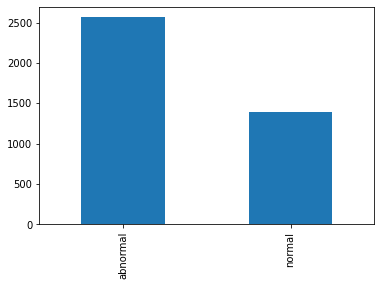

In [ ]:
#@title **Label counts: # of Normals & Abnormals**

label_counts = reports_df.label.value_counts()
print('Abnormal:', label_counts['abnormal'])
print('Normal:', label_counts['normal'])
print()
label_counts.plot.bar();

As we see in the bar graph above, there are almost twice as many abnormal reports as there are normal reports. This will be important to remember as we partition our data into training, validation, and test sets.

# Language Modeling

The types of algorithms we use in NLP work with with numbers, not text. Therefore, we need a way to convert text into numbers. We also want a way for those numbers to contain a little more information about the text they represent. Here, we'll describe the steps in preparing our text for _language modeling_.

## Tokenization

_Tokenization_ is the process by which we split text into chunks or _tokens_. An individual token could be a sentence or phrase, a word, a part of a word, or a single character. Most often, we choose to tokenize at the word or sub-word level.

Each token is assigned a sequential integer value and the collection of token-integer pairs is called our _vocabulary_.


## DistilBERT Tokenization

In this case, since we're training a transformer model, we will use a different tokenizer designed specifically for this task from the HuggingFace Transformers library.

In [ ]:
from transformers import DistilBertTokenizerFast

text = reports_df.sample()['full-text'].values[0]
print(text)

tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
print("Tokenizer vocab size:", len(tokenizer))
ids = tokenizer.encode(text, padding=True, truncation=True, return_tensors='pt')
print(ids[0])
print(tokenizer.decode(ids[0]))

Both lungs remain hyperexpanded. No XXXX focal infiltrates. A small pleural or collection is XXXX present in the right apex. However, it has decreased considerably since the previous examination. Heart size remains normal. COPD with almost completely resolved right apical pleural air collection.
Tokenizer vocab size: 30522
tensor([  101,  2119,  8948,  3961, 23760, 10288,  9739,  5732,  1012,  2053,
        22038, 20348, 15918, 29543,  2015,  1012,  1037,  2235, 20228, 11236,
         2389,  2030,  3074,  2003, 22038, 20348,  2556,  1999,  1996,  2157,
        13450,  1012,  2174,  1010,  2009,  2038, 10548,  9839,  2144,  1996,
         3025,  7749,  1012,  2540,  2946,  3464,  3671,  1012,  8872,  2094,
         2007,  2471,  3294, 10395,  2157, 29197, 20228, 11236,  2389,  2250,
         3074,  1012,   102])
[CLS] both lungs remain hyperexpanded. no xxxx focal infiltrates. a small pleural or collection is xxxx present in the right apex. however, it has decreased considerably since t

## Embedding

While these integers map one-to-one onto our tokens, their numeric value is otherwise meaningless. To embed more information into the numeric representation of our tokens, we employ a process called _language modeling_. We can either use a pre-trained language model for this _embedding_ or we can fine-tune a language model to better model our "radiology language". This latter process is called _transfer learning_.

# Report Classifier Training

In the steps that follow, we will train a second model as a text classifier, using embeddings from our fine-tuned language model. We will then test the classifier on our held-out test set to see how it performs on data it hasn't seen yet.

In [ ]:
# We'll use the Hugging Face datasets library to create our datasets
from datasets import Dataset

dset = Dataset.from_pandas(reports_df)
dset

Dataset({
    features: ['findings', 'impression', 'full-text', 'label', 'id'],
    num_rows: 3955
})

In [ ]:
# Here we perform our train-validation-test splits with a built-in method similar to scikit-learn's function
dsets = dset.train_test_split(test_size=0.15, seed=42)
dsets_clean = dsets["train"].train_test_split(test_size=0.30, seed=42)
dsets_clean["validation"] = dsets_clean.pop("test")
dsets_clean["test"] = dsets["test"]
dsets_clean

DatasetDict({
    train: Dataset({
        features: ['findings', 'impression', 'full-text', 'label', 'id'],
        num_rows: 2352
    })
    validation: Dataset({
        features: ['findings', 'impression', 'full-text', 'label', 'id'],
        num_rows: 1009
    })
    test: Dataset({
        features: ['findings', 'impression', 'full-text', 'label', 'id'],
        num_rows: 594
    })
})

In [ ]:
from datasets import ClassLabel

# We take our categorical labels and wrap them in a class that easily converts back and forth between numerical representation and text
label_names = ['normal', 'abnormal']
labels = ClassLabel(names=label_names)
labels

ClassLabel(num_classes=2, names=['normal', 'abnormal'], names_file=None, id=None)

In [ ]:
# Here we define a function to tokenize our dataset in batches
def preprocess(batch):
    tokens = tokenizer(batch['full-text'], truncation=True, max_length=128)
    tokens['label'] = labels.str2int(batch['label'])
    return tokens


In [ ]:
tokenized_dsets = dsets_clean.map(preprocess, batched=True)
tokenized_dsets

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['attention_mask', 'findings', 'full-text', 'id', 'impression', 'input_ids', 'label'],
        num_rows: 2352
    })
    validation: Dataset({
        features: ['attention_mask', 'findings', 'full-text', 'id', 'impression', 'input_ids', 'label'],
        num_rows: 1009
    })
    test: Dataset({
        features: ['attention_mask', 'findings', 'full-text', 'id', 'impression', 'input_ids', 'label'],
        num_rows: 594
    })
})

In [ ]:
import numpy as np
from transformers import DistilBertForSequenceClassification, Trainer, TrainingArguments
from datasets import load_metric

# This metrics function will output accuracy and F1-score during training & validation
def compute_metrics(eval_preds):
    metric = load_metric("glue", "mrpc")
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

# This step configures our training experiment
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=5,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
    evaluation_strategy='epoch',
    fp16=True
)

# Now we select our model and train it
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased")
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dsets['train'],
    eval_dataset=tokenized_dsets['validation'],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

train_output = trainer.train()

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'pre_classi

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.214200,0.212004,0.922696,0.940458
2,0.209600,0.163065,0.955401,0.966242
3,0.109200,0.144084,0.960357,0.970060


The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: id, findings, impression, full-text.
***** Running Evaluation *****
  Num examples = 1009
  Batch size = 64


Downloading:   0%|          | 0.00/1.86k [00:00<?, ?B/s]

The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: id, findings, impression, full-text.
***** Running Evaluation *****
  Num examples = 1009
  Batch size = 64
The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: id, findings, impression, full-text.
***** Running Evaluation *****
  Num examples = 1009
  Batch size = 64


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=441, training_loss=0.23495442634807423, metrics={'train_runtime': 60.3191, 'train_samples_per_second': 116.978, 'train_steps_per_second': 7.311, 'total_flos': 220984598201664.0, 'train_loss': 0.23495442634807423, 'epoch': 3.0})

In [ ]:
# Finally we save our trained model for later use
trainer.save_model('fine-tuned')

Saving model checkpoint to fine-tuned
Configuration saved in fine-tuned/config.json
Model weights saved in fine-tuned/pytorch_model.bin
tokenizer config file saved in fine-tuned/tokenizer_config.json
Special tokens file saved in fine-tuned/special_tokens_map.json


## Testing the model

Now that our model is trained, let's test it on our held-out test dataset.

In [ ]:
test_output = trainer.predict(tokenized_dsets['test'])
print(test_output.metrics)

The following columns in the test set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: id, findings, impression, full-text.
***** Running Prediction *****
  Num examples = 594
  Batch size = 64


{'test_loss': 0.21703416109085083, 'test_accuracy': 0.9461279461279462, 'test_f1': 0.9548022598870056, 'test_runtime': 1.7838, 'test_samples_per_second': 332.997, 'test_steps_per_second': 5.606}


# Creating a Pipeline for Inference

In [ ]:
from transformers import pipeline

classifier = pipeline("text-classification", model="fine-tuned")

loading configuration file fine-tuned/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "problem_type": "single_label_classification",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.12.2",
  "vocab_size": 30522
}

loading configuration file fine-tuned/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  

In [ ]:
sample_text = "Normal heart size and mediastinal contours. The lungs are well-aerated. Trace left apical pneumothorax. No pleural effusion. No displaced rib fractures."
classifier(sample_text[0])

full-text     Heart size normal. Lungs are clear. 5 mm right apical granuloma unchanged
label                                                                          abnormal
Name: 316, dtype: object
